# Lion Cheetah Classification task

Baed on the following Kaggle data set: https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import imghdr

/var/folders/7f/lz8t8yrj0755nqv_kddd2ps00000gn/T/ipykernel_57482/3672777338.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [15]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [36]:
# Removing dodgy images

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

data_dir = 'images'
for image_class in os.listdir(data_dir):
    # Ignore .DS_Store file
    if image_class == ".DS_Store":
        continue
    
    class_dir = os.path.join(data_dir, image_class)
    
    for image in os.listdir(class_dir):
        # Ignore .DS_Store file
        if image == ".DS_Store":
            continue
        
        image_path = os.path.join(class_dir, image)
        # Process image_path as needed

        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))


# Load Data

In [37]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [54]:
# create data pipeline
data = tf.keras.utils.image_dataset_from_directory('images')

Found 200 files belonging to 2 classes.


In [40]:
# get access to data pipeline --> automatically reshapes images
data_iterator = data.as_numpy_iterator()

In [41]:
# accessing the data pipeline itself
batch = data_iterator.next()

In [44]:
batch[0].shape

(32, 256, 256, 3)

In [45]:
batch[1]

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1], dtype=int32)

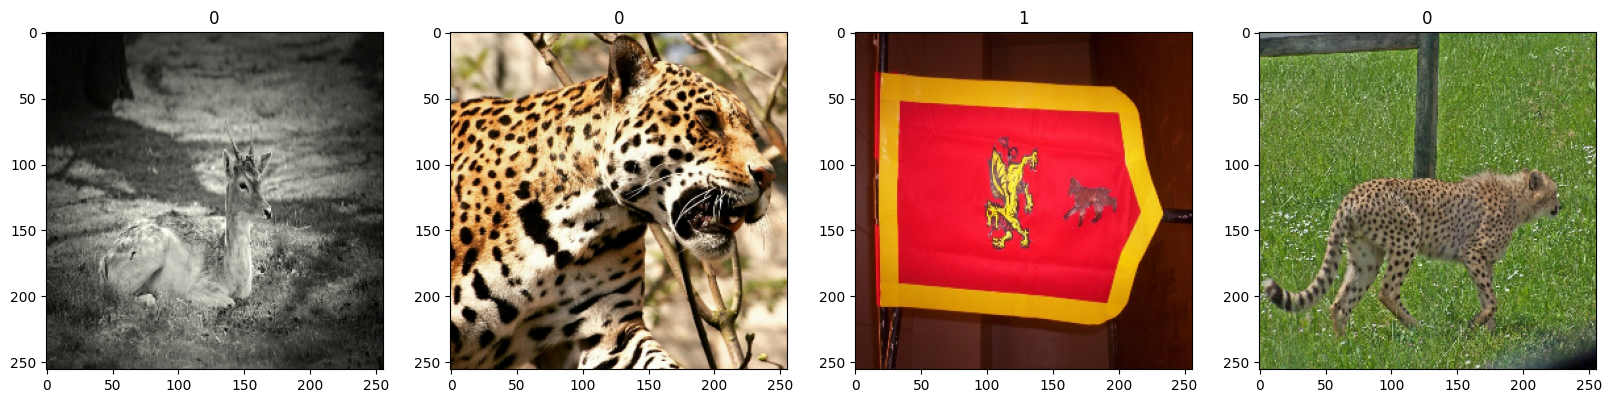

In [46]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Preprocessing

In [55]:
# transform the batch array
# since the values inside the array represent rgb values, the max value is 255
data = data.map(lambda x, y: (x/255, y))

scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

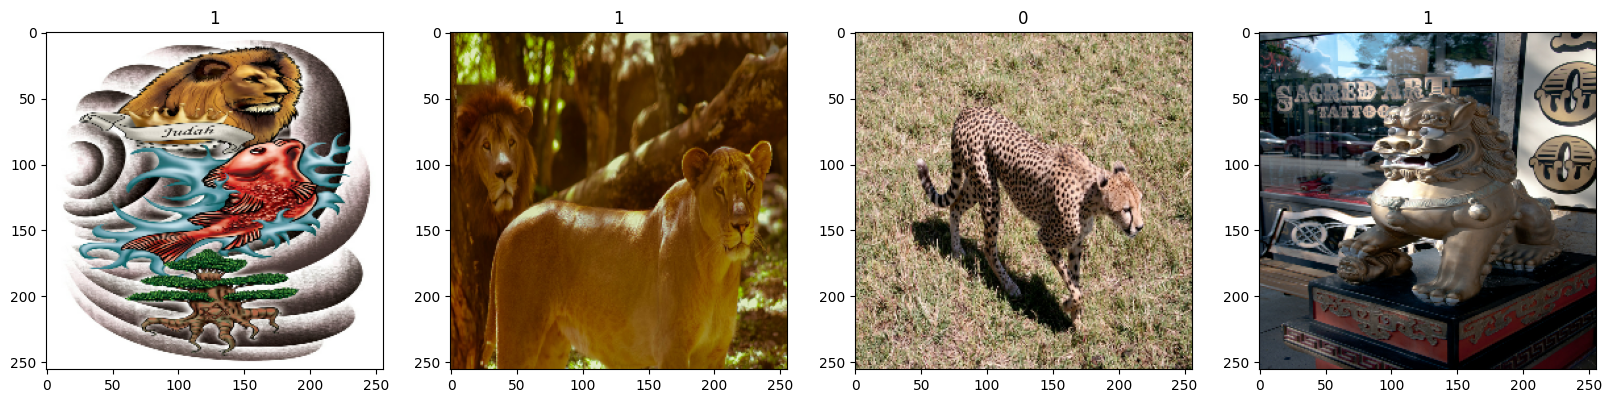

In [56]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [65]:
# max value of batch must be 1

def check_max_value(batch):
    max_val = batch[0].max()
    if max_val != 1:
        print("Error: Maximum value is not equal to 1. Actual value:", max_val)
    else:
        print("The max value of the batch is equal to 1, so please continue")

# execute the function
check_max_value(batch)

The max value of the batch is equal to 1, so please continue


In [66]:
len(data)

7

In [72]:
train_size = int(len(data)*0.7) # train data size
val_size = int(len(data)*0.2)+1 # validation of the model
test_size = int(len(data)*0.1)+1 # used for final evaluation state

In [73]:
# Data separation
# For training, validation, and eventually testing
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Model

In [75]:
# important further tensorflow libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [76]:
model = Sequential()

In [77]:
model.add(Conv2D(16, (3,3), 1, activation= "relu", input_shape=(256,256,3))) # 16 Filters, 3x3 window, stride=1
model.add(MaxPool2D()) # compresses information, only takes high values in account

model.add(Conv2D(32, (3,3), 1, activation= "relu" ))
model.add(MaxPool2D()) 

model.add(Conv2D(16, (3,3), 1, activation= "relu" ))
model.add(MaxPool2D()) 

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # transforms input to value between 0 and 1

In [78]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [79]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [81]:
# Creates the logging function. Callbacks are logged to observe model performance during time
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [82]:
# Train the model
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 2s 422ms/step - loss: 1.5878 - accuracy: 0.5156 - val_loss: 0.7813 - val_accuracy: 0.5000
Epoch 2/20
4/4 [==============================] - 2s 430ms/step - loss: 0.7114 - accuracy: 0.5234 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 2s 406ms/step - loss: 0.6839 - accuracy: 0.6250 - val_loss: 0.6732 - val_accuracy: 0.7031
Epoch 4/20
4/4 [==============================] - 2s 399ms/step - loss: 0.6882 - accuracy: 0.5391 - val_loss: 0.6696 - val_accuracy: 0.5781
Epoch 5/20
4/4 [==============================] - 2s 400ms/step - loss: 0.6955 - accuracy: 0.5156 - val_loss: 0.6697 - val_accuracy: 0.5469
Epoch 6/20
4/4 [==============================] - 2s 398ms/step - loss: 0.6775 - accuracy: 0.5703 - val_loss: 0.6648 - val_accuracy: 0.8281
Epoch 7/20
4/4 [==============================] - 2s 399ms/step - loss: 0.6645 - accuracy: 0.7578 - val_loss: 0.6545 - val_accuracy: 0.7188
Epoch 8/20
4/4 [====

In [84]:
# show history performance
hist.history

{'loss': [1.5877885818481445,
  0.7114174365997314,
  0.6839433312416077,
  0.6881565451622009,
  0.695469856262207,
  0.677548885345459,
  0.664523720741272,
  0.6487165689468384,
  0.6228017210960388,
  0.5807961225509644,
  0.5619239807128906,
  0.505729079246521,
  0.4757832884788513,
  0.4375067949295044,
  0.36031076312065125,
  0.3078441619873047,
  0.2675318121910095,
  0.25773856043815613,
  0.2121139019727707,
  0.22849494218826294],
 'accuracy': [0.515625,
  0.5234375,
  0.625,
  0.5390625,
  0.515625,
  0.5703125,
  0.7578125,
  0.6796875,
  0.7578125,
  0.7578125,
  0.765625,
  0.75,
  0.796875,
  0.8203125,
  0.90625,
  0.90625,
  0.9375,
  0.90625,
  0.8984375,
  0.890625],
 'val_loss': [0.7812865972518921,
  0.6939408183097839,
  0.6732301712036133,
  0.6696262359619141,
  0.6697413921356201,
  0.6647860407829285,
  0.6544852256774902,
  0.6304655075073242,
  0.5797944664955139,
  0.5557911396026611,
  0.5658440589904785,
  0.48421186208724976,
  0.45478618144989014,
  

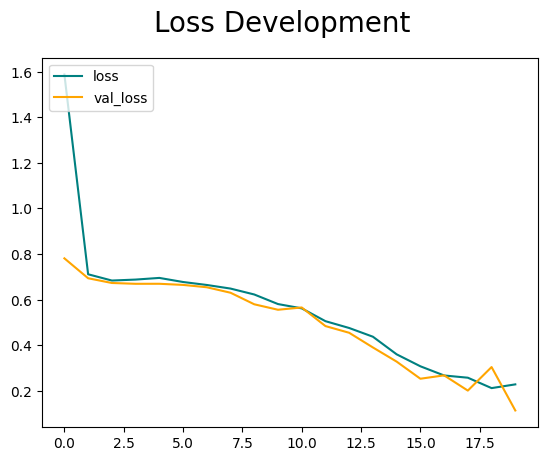

In [86]:
# plot performance

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss Development', fontsize=20)
plt.legend(loc='upper left')
plt.show()
